# Выбор локации для скважины

Мы работам в добывающей компании «ГлавРосГосНефть» и нам предстоит решить, где бурить новую скважину.

Для работы нам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Нам необходимо построить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Для этого мы проанализируем возможную прибыль и риски техникой *Bootstrap.*

Условия задачи следующие:

Для выбора локации мы будем придерживатья следующих шагов:

- Для каждого региона, в котором найдено месторождение, у нас есть значения признаков;
- Для этих регонов мы построим модель и оценим объём запасов. Для обучения модели нам подходит только линейная регрессия, так как остальные алгоритмы недостаточно предсказуемые;
- Выберем месторождения с самым высокими оценками значений. При выборе количества месторождений мы будем отталкиваться от бюджета компании и стоимости разработки одной скважины. Бизнес-показатели, которых мы будем придерживаться, следующие:
  - При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
  - Бюджет на разработку скважин в регионе — 10 млрд рублей.
  - При нынешних ценах один баррель сырья приносит 450 рублей дохода.
  - Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков мы оставим лишь те регионы, в которых вероятность убытков меньше 2.5% и уже среди них выберем регион с наибольшей средней прибылью.

_____

## Загрузим и подготовим данные

Импортируем необходимые для работы библиотеки и модули:

In [1]:
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import seaborn as sns

from sklearn.compose import ColumnTransformer 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, RobustScaler

import joblib
import os

RANDOM_STATE = 0

Функции для отрисовки графиков соберём в одном месте, так код будет выглядеть чуть аккуратнее:

In [2]:
def general_inspection(dfs):
    """функция для отрисовки распределения признаков"""
    
    for df in dfs:
        fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(12, 4))
        fig.suptitle(f'распределение значений в {df.name}', fontsize=16, fontweight='bold')
        for i, feature in enumerate(df.columns[1:]):
            sns.histplot(data=df, x=df[feature], kde=True, color='#3653CA', ax=ax[0][i])
            sns.boxplot(data=df, x=df[feature], color='#627EEF', linewidth=0.5, width=0.3, ax=ax[1][i])
        plt.subplots_adjust(hspace=0.2, wspace=0.45);
        
def correlation_between_features(dfs):
    """функция для отрисовки корреляции признаков"""
    
    fig, ax = plt.subplots(ncols=3, figsize=(12, 3.5))
    fig.suptitle(f'корреляционные матрицы', fontsize=16, fontweight='bold')
    sns.set(font_scale=0.75)
    cmap = mcolors.LinearSegmentedColormap.from_list('my_palette', ['#C4CCEC', '#3E60EA'])
    for i, df in enumerate(dfs):
        corr_matrix = df.corr().round(2)

        mask = np.zeros_like(corr_matrix)
        mask[np.triu_indices_from(mask)] = True

        sns.heatmap(corr_matrix, annot=True, linewidths=.3, cmap=cmap, mask=mask, ax=ax[i])
        ax[i].set_title(df.name, fontweight='bold')
    fig.tight_layout();

    
def distribution_of_truth_and_prediction(y_valid, y_pred):
    """функция для отрисковки в одной фигуре распределения y_valid и y_pred"""
    
    plt.figure(figsize=(12, 3))
    plt.style.use('seaborn-white')
    sns.histplot(y_valid[i], bins=100, kde=True, color='#1C42DC', alpha=0.5, label='истинные значения')
    sns.histplot(y_pred[i], bins=100, kde=True, color='#13A22A', alpha=0.5, label='предсказанные значения')
    plt.title(f'распределение значений для {dfs[i].name}\nRMSE = {rmse[-1]:.4f}'
              f'\nсредний запас сырья = {avg_product_pred[-1]:.4f}', fontweight='bold', fontsize=14)
    plt.legend()
    plt.grid(axis='y', linewidth=0.5);

    
def income_earning_schedule(dfs, well_development_income):
    """функция для отрисовки столбчатой диаграммы"""
    
    plt.figure(figsize=(11, 3))
    plt.bar([dfs[0].name, dfs[1].name, dfs[2].name], 
            well_development_income, color='#AED6F1', ec='#1361A2')
    plt.ylabel('млн.руб')
    plt.title('доход с разработки месторождения по ТОП-200 скважин', fontweight='bold', fontsize=14)
    plt.grid(axis='y', linewidth=0.5)
    for i, v in enumerate(well_development_income):
        plt.text(i-0.22, v-0.7, str(round(v, 2))+' млн. руб', fontweight='bold', fontsize=14)

        
def profit_and_risk_chart(dfs, confidence_interval, average_profit, risks):
    """функция для отрисовки финальных значений прибыли, % риска и доверительного интервала"""
    
    fig, ax = plt.subplots(nrows=3, figsize=(12, 8))
    fig.suptitle(f'Прибыль и риски по месторожденям', fontsize=16, fontweight='bold')
    means = [np.mean(i) for i in confidence_interval]
    lower = [v[0] for v in confidence_interval]
    upper = [v[1] for v in confidence_interval]

    for i in range(3):
        ax[0].bar([dfs[0].name, dfs[1].name, dfs[2].name], average_profit, 
                  color='#AED6F1', ec='#1361A2', alpha=.3)
        for i, v in enumerate(average_profit):
            ax[0].text(i-0.25, v-100, str(round(v, 2))+' млн. руб', fontweight='bold', fontsize=14)
        ax[0].set_title('Средняя прибыль по региону', fontweight='bold', fontsize=14)
        ax[0].set_ylabel('млн. руб.')
        ax[0].grid(axis='y', linewidth=0.5)
        ax[1].errorbar(range(3), means, 
                       yerr=[np.array(means)-np.array(lower), np.array(upper)-np.array(means)], 
                       fmt='o', ecolor='#3269E8', capsize=5)
        ax[1].minorticks_on()
        ax[1].grid(which='major', linewidth=0.5)
        ax[1].grid(which='minor', axis='y', linewidth=0.25, linestyle='--');
        ax[1].set_xticks(range(3)) 
        ax[1].set_xticklabels([dfs[0].name, dfs[1].name, dfs[2].name]) 
        ax[1].set_title('Доверительные интервалы', fontweight='bold', fontsize=14)
        ax[1].set_ylabel('млн. руб.')

        ax[2].bar([dfs[0].name, dfs[1].name, dfs[2].name], risks, color='#F3C199', ec='#DF5B2E', alpha=.3)
        for i, v in enumerate(risks):
            ax[2].text(i-0.06, v-0.6, str(round(v, 2))+'%', fontweight='bold', fontsize=10)
        ax[2].set_title('риски в %', fontweight='bold', fontsize=14)
        ax[2].set_ylabel('%')
        ax[2].grid(axis='y', linewidth=0.5)

    plt.subplots_adjust(hspace=0.2, wspace=0.45);

Загрузим данные и посмотрим на них:

In [3]:
dfs = []
for i in range(3):
    try:
        df = pd.read_csv(f'geo_data_{i}.csv')
    except FileNotFoundError:
        df = pd.read_csv(f'https://code.s3.yandex.net/datasets/geo_data_{i}.csv')
    dfs.append(df)
    
df1, df2, df3 = dfs
df1.name, df2.name, df3.name = 'регион_1', 'регион_2', 'регион_3'

<div class="alert alert-success">
<h2> Комментарий ревьюера ✔️ <a class="tocSkip"> </h2>

Здорово, что ты используешь конструкцию `try-except`, это повышает отказоустойчивость кода

</div>


In [4]:
display(df1.name, df1.head(3), df1.tail(3), df2.name, df2.head(3), 
        df2.tail(3), df3.name, df3.head(3), df3.tail(3))

'регион_1'

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647


,id,f0,f1,f2,product
99997,3rnvd,1.029585,0.018787,-1.348308,64.375443
99998,7kl59,0.998163,-0.528582,1.583869,74.040764
99999,1CWhH,1.764754,-0.266417,5.722849,149.633246


'регион_2'

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305


,id,f0,f1,f2,product
99997,09gWa,-7.378891,-3.084104,4.998651,137.945408
99998,rqwUm,0.665714,-6.152593,1.000146,30.132364
99999,relB0,-3.426139,-7.794274,-0.003299,3.179103


'регион_3'

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910


,id,f0,f1,f2,product
99997,tKPY3,-1.199934,-2.957637,5.219411,157.080080
99998,nmxp2,-2.419896,2.417221,-5.548444,51.795253
99999,V9kWn,-2.551421,-2.025625,6.090891,102.775767


In [5]:
display(df1.name); df1.info(); display(df2.name); df2.info(); display(df3.name); df3.info()

'регион_1'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


'регион_2'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


'регион_3'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [6]:
display(df1.name, df1.describe(), df2.name, df2.describe(), df3.name, df3.describe())

'регион_1'

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


'регион_2'

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


'регион_3'

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


Проверим на дубликаты и не найдём их:

In [7]:
print(f'{df1.duplicated().sum()}\n{df2.duplicated().sum()}\n{df3.duplicated().sum()}')

0
0
0


Проверим на уникальность значений:

In [8]:
for df in dfs:
    print(f'{df.name}:\n{df.nunique()}\n')

регион_1:
id          99990
f0         100000
f1         100000
f2         100000
product    100000
dtype: int64

регион_2:
id          99996
f0         100000
f1         100000
f2         100000
product        12
dtype: int64

регион_3:
id          99996
f0         100000
f1         100000
f2         100000
product    100000
dtype: int64



Посмотрим на распределение и корреляцию признаков:

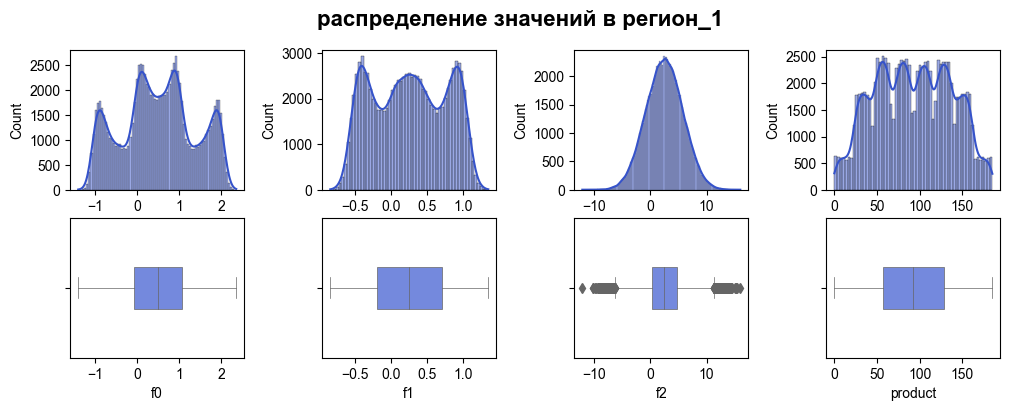

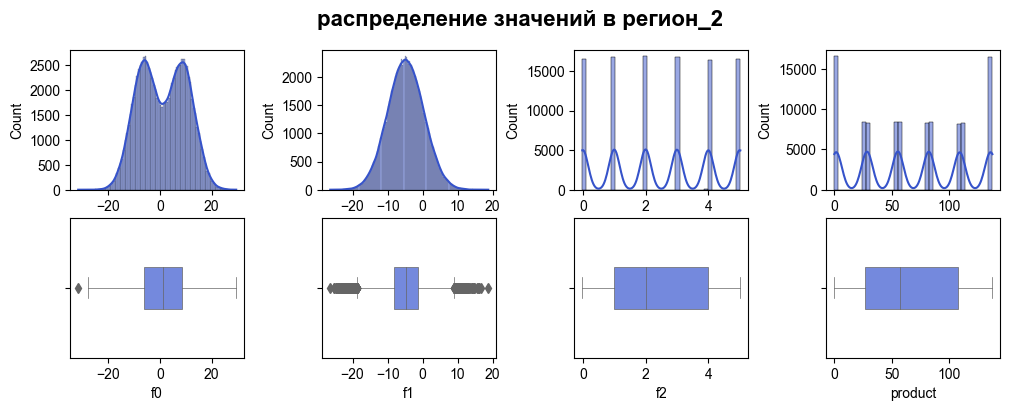

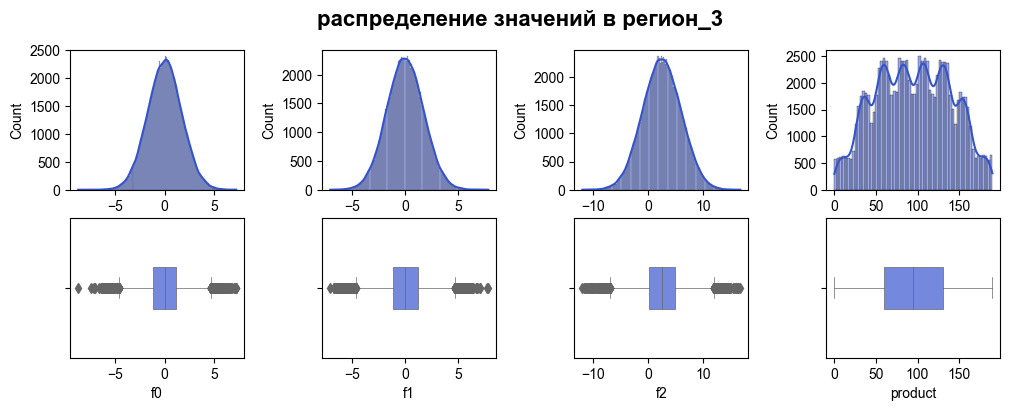

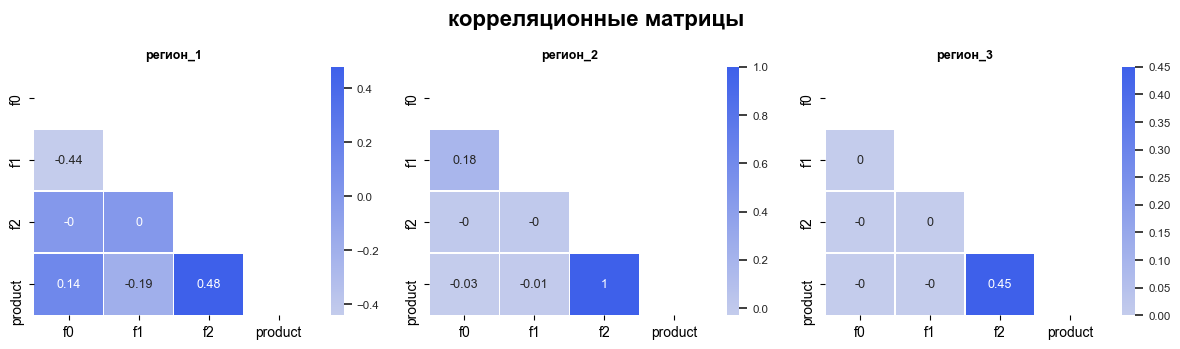

In [9]:
general_inspection(dfs)
correlation_between_features(dfs)

**Предварительный вывод**. На данном этапе мы:

- загрузили данные и посмотрели на них с разных сторон
- признаки в датасетах по всем регионам не имеют пропусков
- типы данных в признаках соответствуют их "синтетическому" содержимому
- явных дубликатов в наблюдениях нет, а вот значения уникальны не везде:
  - несколько id не уникальны
  - значений product в df2 всего 12, их распределение напоминает частокол. Как-то осмысленно интерпретировать причину такого распределения значений для product по синтетическим данным не представляется возможным. Но мы будем помнить о такой особенности в регионе df2, так как малое количество уникальных значений в таргете может влиять на поведение алгоритма машинного обучения
- на графиках можем видеть большой размах в распределении некоторых значений, похожий на выбросы. В особенности это заметно в 3-м регионе. Мы не можем быть наверняка уверены в том, что это выбросы, а не просто особенность распределения синтетических данных, в действительности важная для описания месторождения. Но учтём этот факт в дальнейшем исследовании.  
- признак f2 сильно коррелирует с признаком product во всех регионах, однако во втором регионе мы видим прямую зависимость между признаками f2 и product. Такое вот ещё одно интересное наблюдение по второму региону

Перед применением модели мы:
- удалим столбец id, так как он неинформативен для исследования
- сами признаки будем шкалировать, так как они имеют разный масштаб значений. Для этого применим робастное масштабирование RobustScaler, так как оно в своей формуле применяет медиану и интерквартильный размах: $s_{ij}=\frac{x_{ij} - x_{j \: median}}{Q_3(x_j)-Q_1(x_j)}$ за счёт чего делает масштабирование более устойчивым к возможным выбросам в данных, ведь для нас в исследовании важно сохранять информацию о рапределении данных

_____

## Обучим ML-модели и проверим их

Разделим данные на тренировочные и валидационные в соотношении 3:1 

In [10]:
X_train, X_valid = [], []
y_train, y_valid = [], []

for df in dfs:
    X_train_i, X_valid_i, y_train_i, y_valid_i = train_test_split(
        df.drop('product', axis=1), df['product'], test_size=.25, random_state=RANDOM_STATE)
    X_train.append(X_train_i)
    X_valid.append(X_valid_i)
    y_train.append(y_train_i)
    y_valid.append(y_valid_i)

Посмотрим на получившиеся размеры:

In [11]:
for i in range(3):
    print(f'{dfs[i].name}:\n\tX_train: {X_train[i].shape}  X_valid: {X_valid[i].shape}'
          f'\n\ty_train: {y_train[i].shape}    y_valid: {y_valid[i].shape}')

регион_1:
	X_train: (75000, 4)  X_valid: (25000, 4)
	y_train: (75000,)    y_valid: (25000,)
регион_2:
	X_train: (75000, 4)  X_valid: (25000, 4)
	y_train: (75000,)    y_valid: (25000,)
регион_3:
	X_train: (75000, 4)  X_valid: (25000, 4)
	y_train: (75000,)    y_valid: (25000,)


Размер выборок получился правильный, сохраним их:

In [12]:
folder_name = 'choosing_a_location_for_an_oil_well'
try:
    os.mkdir(folder_name)
except FileExistsError:
    pass

for i in range(3):
    joblib.dump(X_train[i], os.path.join(folder_name, f'{dfs[i].name}_X_train'))
    joblib.dump(X_valid[i], os.path.join(folder_name, f'{dfs[i].name}_X_valid'))
    joblib.dump(y_train[i], os.path.join(folder_name, f'{dfs[i].name}_y_train'))
    joblib.dump(y_valid[i], os.path.join(folder_name, f'{dfs[i].name}_y_valid'))

Создадим пайплайн для обработки данных, в котором в препроцессоре будем удалять id и шкалировать данные, а потом всё это оборачивать в линейную регрессию:

In [13]:
def drop_id_column(X):
    return X.drop('id', axis=1)

preprocessor = ColumnTransformer(
    transformers=[
        ('drop_id', FunctionTransformer(drop_id_column), ['id']),
        ('scale', RobustScaler(), ['f0', 'f1', 'f2'])])

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', LinearRegression())])

Обучим модель, сделаем предсказание на валидационных данных, посчитаем метрики RMSE, MAE и средний запас сырья. Дополнительно отрисуем распределение значений истинных и предсказанных:

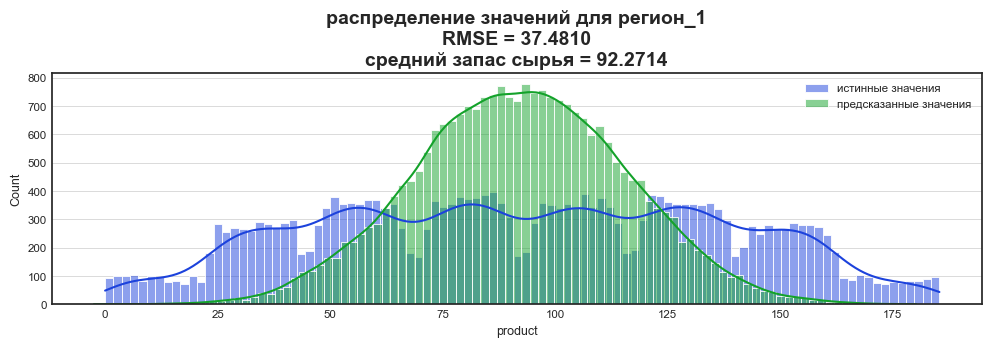

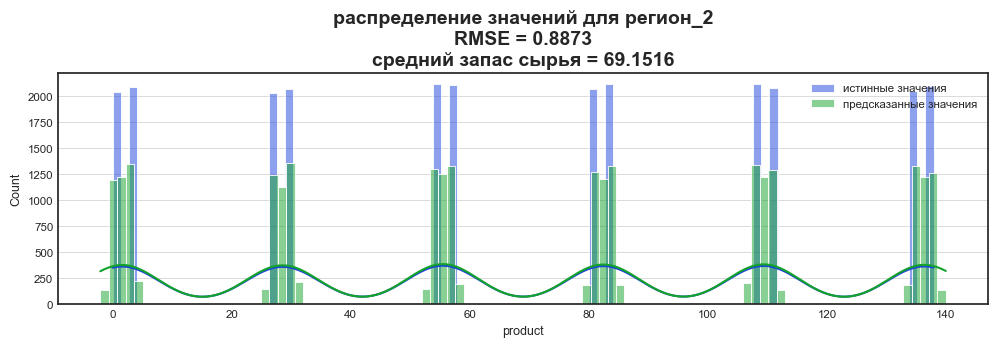

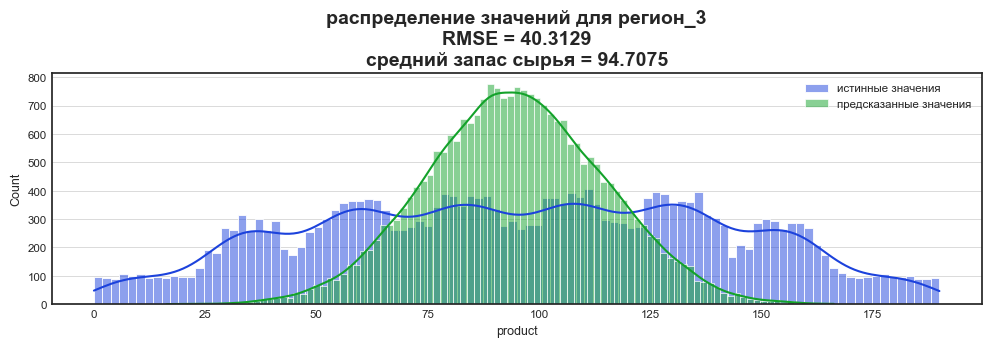

In [14]:
y_pred, avg_product_pred, avg_product_valid, mae, rmse, pipeline_list = [], [], [], [], [], []
for i in range(3):
    pipeline.fit(X_train[i], y_train[i])
    pipeline_list.append(pipeline)
    predict = pipeline.predict(X_valid[i])
    
    y_pred.append(predict)
    avg_product_pred.append(np.mean(predict))
    avg_product_valid.append(np.mean(y_valid[i]))
    rmse.append(np.sqrt(mean_squared_error(y_valid[i], y_pred[-1])))
    mae.append(mean_absolute_error(y_valid[i], y_pred[-1]))
    
    distribution_of_truth_and_prediction(y_valid, y_pred)

Сохраним обученные по регионам пайплайны:

In [15]:
for i in range(3):
    joblib.dump(pipeline_list[i], os.path.join(folder_name, f'{dfs[i].name}_pipeline'))

Соберём все показатели в единую таблицу:

In [16]:
pd.DataFrame({'регион': [dfs[0].name, dfs[1].name, dfs[2].name], 'RMSE': rmse, 'MAE': mae,
              'предсказанный средний запас сырья': avg_product_pred, 
              'истинный средний запас сырья': avg_product_valid,})

,регион,RMSE,MAE,предсказанный средний запас сырья,истинный средний запас сырья
0,регион_1,37.481009,30.770329,92.271449,92.466785
1,регион_2,0.887257,0.715548,69.151624,69.154361
2,регион_3,40.312907,33.021531,94.707531,95.471317


**Предварительный вывод**. На данном этапе мы:
- подготовили данные для машинного обучения
- создали пайплайн для обработки данных
- обучили и проверили модель для каждого региона
- для оценки качества предсказания мы использовали две метрки: 
  - ```RMSE``` (Root Mean Squared Error) -  эта метрика измеряет среднеквадратическое отклонение прогнозируемых значений от фактических $RMSE=\sqrt{\frac{1}{n}\sum_{i=1}^{n}(y_i-\hat{y_i})^2}$ 
  - ```MAE``` (Mean Absolute Error) - она измеряет среднее абсолютное отклонение между предсказанными значениями и фактическими и вычисляется по формуле $MAE = \frac{1}{n}\sum_{i=1}^{n}|y_i - \hat{y_i}|$  
- MAE более устойчива к выбросам в данных, чем MSE, так как в своей формуле не учитывает квадрат разности, именно поэтому полезно для нашей задачи сравнить разницу между MAE и RMSE
  - Значение RMSE и MAE для второго региона предельно низкое. Наверняка такой показатель достигается за счёт прямой взаимосвязи product и признака f2
  - при этом мы видим, что прогнозируемое количество запасов сырья во втором регионе ниже, чем в первом и третьем
  - а предсказанные средние значения практически аналогичны реальным средним значениям запасов сырья по всем трём регионам. Тут, что называется, модель попала в яблочко и не обманула нас.
- Для бóльшей наглядности мы отобразили распределение истинных и предсказанных значений на графиках. По графикам видно, что:
  - Предсказанные значения для 1 и 3-го регионов похожи на нормальное распределение, тогда как истинные значения в этих регионах распределены скорее мультимодально. Но наша линейная модель не увидела такой особенности значений и фактически "обрезала" края действительного распределения
  - сравнивая значения MAE и RMSE мы можем подтвердить те самые "хвостики-выбросы" в распределении, которые хорошо видно на графиках. Конечно, это не выбросы, а особенность распределения данных, но модель не учла эту особенность из-за их большого разброса, именно поэтому показатели RMSE выше, чем MAE
  - для второго региона модель нашла частокол распределения достаточно точно, что, опять же, подтверждается самыми лучшими значениями RMSE и MAE. Очевидно, для модели было проще подстроиться под 12 уникальных значений-не выбросов, которые есть у таргета product в третьем регионе. А это все значения вообще, что там есть.
  
Перед подготовкой к расчёту прибыли предварительно предположим, что регионы 1 и 3 для нас могут представлять бóльший  интерес, так как, несмотря на то, что значения метрик у них хуже, чем у региона 2, средний запас сырья у них выше и этот факт подверждается работой линейных ML-моделей

_____

## Подготовим данные для расчёта прибыли

Сохраним все ключевые для расчётов данные в отдельных переменных. А значения у нас такие:

- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки
- Бюджет на разработку скважин в регионе — 10 млрд рублей
- При нынешних ценах один баррель сырья приносит 450 рублей дохода
- Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей
- После оценки рисков мы оставим лишь те регионы, в которых вероятность убытков меньше 2.5%

In [17]:
# При разведке региона исследуют 500 точек:
RESEARCH_CENTERS = 500

# из которых с помощью машинного обучения выбирают 200 лучших для разработки:
BEST_RESEARCH_CENTERS = 200

# Бюджет на разработку скважин в регионе:
DEVELOPMENT_BUDGET = 1e10

# При нынешних ценах один баррель сырья приносит 450 рублей дохода:
BARREL_PROFIT = 450

# Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей:
ONE_PRODUCT_PROFIT = BARREL_PROFIT * 1000

# После оценки рисков мы оставим лишь те регионы, в которых вероятность убытков меньше 2.5%:
PROBABILITY_OF_LOSS = 2.5

Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины и сравним полученный объём сырья со средним запасом в каждом регионе, полученном в предсказании.

Для безубыточности разработки меторождения в регионе объём нефти в нём должен быть таким:

In [18]:
required_volume_in_the_region = DEVELOPMENT_BUDGET / ONE_PRODUCT_PROFIT
print(f'{required_volume_in_the_region:.4f}')

22222.2222


Тогда запасов нефти в скважине должно быть столько:

In [19]:
required_stock_in_the_well = required_volume_in_the_region / BEST_RESEARCH_CENTERS
print(f'{required_stock_in_the_well:.4f}')

111.1111


Сравним полученное значение со средними значениями, предсказанными для каждого из регионов: 

In [20]:
pd.DataFrame({'регион': [dfs[0].name, dfs[1].name, dfs[2].name],
              'предсказанный объём': avg_product_pred,
              'необходимый объём': [required_stock_in_the_well]*3,
              'не хватает': [avg_product_pred[0]-required_stock_in_the_well,
                             avg_product_pred[1]-required_stock_in_the_well,
                             avg_product_pred[2]-required_stock_in_the_well]})

,регион,предсказанный объём,необходимый объём,не хватает
0,регион_1,92.271449,111.111111,-18.839663
1,регион_2,69.151624,111.111111,-41.959487
2,регион_3,94.707531,111.111111,-16.403580


Получается, что, согласно предсказанному моделью среднему объёму запасов в месторождениях, все три региона не дотягивают до объёма, неоходимого для безубыточности разработки 200-т скважин и это может говорить о том, что мы не можем рандомно выбирать скважины для разработки, ведь в таком случае нас может ждать неудача, вот так поворот. Но рано огорчаться.

Рассчитаем прибыль по скважинам, для которых наша модель вернула максимальное значение предсказаний. Как мы это будем делать:
- выберем срез из ТОП-200 скважин с максимальными значениями предсказаний и просуммируем для них значение объёма сырья
- полученную сумму умножим на доход с единицы продукта и вычтем из неё стоимость разработки скважины:

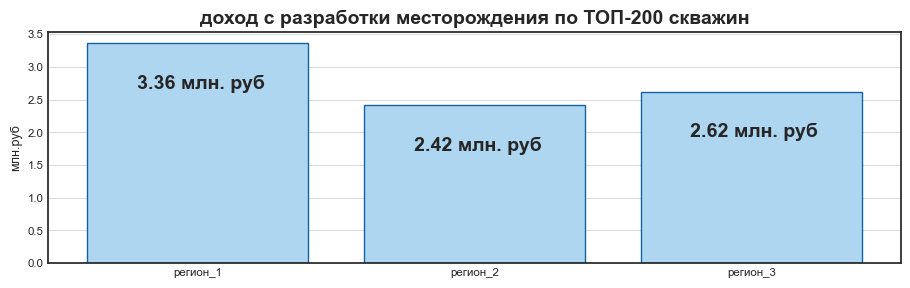

In [21]:
def profitability_calculation(y_valid, y_pred, count=BEST_RESEARCH_CENTERS, bp=BARREL_PROFIT,
                              opp=ONE_PRODUCT_PROFIT, db=DEVELOPMENT_BUDGET):
    y_pred = y_pred.sort_values(ascending=False)
    selected = y_valid[y_pred.index][:count]
    return opp * selected.sum() - db

well_development_income = []
for i in range(3):
    y_pred_ = pd.Series(y_pred[i], index=y_valid[i].index)
    well_development_income.append(profitability_calculation(y_valid[i], y_pred_)/1e9)
    
income_earning_schedule(dfs, well_development_income)

**Предварительный вывод**. На данном этапе мы:
- подготовили данные для дальнейшего расчёта прибыли
- рассчитали достаточный объём сырья для безубыточной разработки новой скважины
- сравнили полученное значение со средними значениями, предсказанными для каждого из регионов. В результате сравнения выяснилось, что все три региона не дотягивают до объёма, неоходимого для безубыточности разработки
- но мы рассчитали так же прибыль по скважинам, для которых наша модель вернула максимальное значение предсказаний. Для этого мы взяли топ-200 скважин по предсказанию. И согласно расчётам, исходя из потенциального дохода с каждой единицы продукта за вычетом стоимости разработки самой скважины, несмотря на то, что все все три региона по общему предсказанию не дотягивают до безубыточности разработки, в каждом регионе мы можем получить прибыль от разработки ТОП-200 скважин и при таком подходе ни один из трёх регионов не будет убыточным. Это не может не радовать, значит есть смысл проводить исследование дальше
- предварительно видим, что лучшие финансовые результаты по ТОП-200 скважин показывает первый регион. 

_____

## Рассчитаем прибыли и риски 

Для нахождения распределения прибыли мы будем использовать Bootstrap-технику на 1000 выборок. Найдём среднюю прибыль, 95%-й доверительный интервал и риск убытков. Результат выведем на экран и отрисуем на графиках:

In [22]:
state = np.random.RandomState(RANDOM_STATE)

def bootstrap(y_valid, y_pred, n=RESEARCH_CENTERS, thousand_samples=1000):
    values, lost = [], 0
    
    for i in range(thousand_samples):
        target_sample = y_valid.sample(replace=True, random_state=state, n=n)
        y_pred_sample = y_pred[target_sample.index]
        profit = profitability_calculation(y_valid, y_pred_sample)
        if profit < 0:
            lost +=1
        values.append(profit)
    
    values = pd.Series(values)
    lower = values.quantile(.025)
    upper = values.quantile(.975)
    average = values.mean()
    risk = (values < 0).mean()
    return average, lower, upper, risk

Данные по регион_1:

Средняя прибыль по региону: 442.87 млн. руб.
95% доверительный интервал (млн. руб.):
	 [-49.23 : 921.13]

Риск: 3.9%
слишком высокая вероятность убытков
 ________________________________________ 

Данные по регион_2:

Средняя прибыль по региону: 469.54 млн. руб.
95% доверительный интервал (млн. руб.):
	 [85.18 : 850.89]

Риск: 0.8%
допустимая вероятность убытков
 ________________________________________ 

Данные по регион_3:

Средняя прибыль по региону: 384.42 млн. руб.
95% доверительный интервал (млн. руб.):
	 [-151.02 : 916.80]

Риск: 6.9%
слишком высокая вероятность убытков
 ________________________________________ 



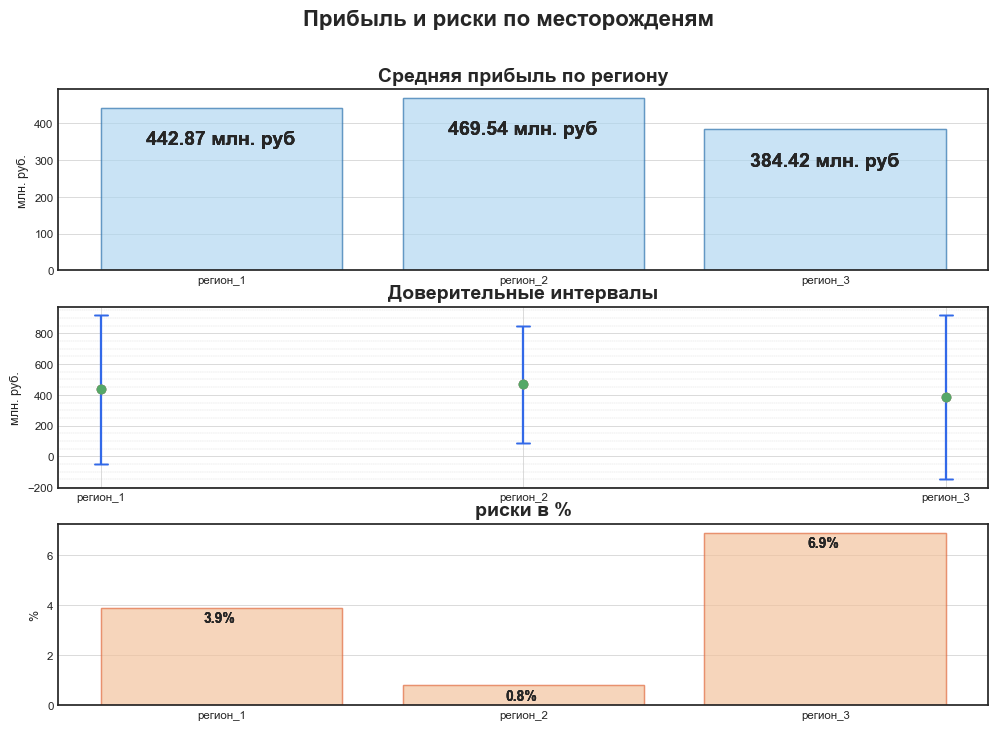

In [23]:
average_profit, confidence_interval, risks = [], [], []
for i in range(3):
    y_pred_ = pd.Series(y_pred[i], index=y_valid[i].index)
    average, lower, upper, risk = bootstrap(y_valid[i], y_pred_)
    
    average_profit.append(average/1e6)
    confidence_interval.append((lower/1e6, upper/1e6))
    risks.append(risk*100)
    
    print(f'Данные по {dfs[i].name}:\n\nСредняя прибыль по региону: '
          f'{average_profit[-1]:.2f} млн. руб.\n95% доверительный интервал (млн. руб.):'
          f'\n\t [{confidence_interval[-1][0]:.2f} : {confidence_interval[-1][1]:.2f}]'
          f'\n\nРиск: {risks[-1]:.1f}%')
    if risks[-1] >= PROBABILITY_OF_LOSS:
        print('слишком высокая вероятность убытков\n', '_'*40, '\n')
    else:
        print('допустимая вероятность убытков\n', '_'*40, '\n')
profit_and_risk_chart(dfs, confidence_interval, average_profit, risks)

**Предварительный вывод**. На данном этапе мы:
- для нахождения распределения прибыли применили Bootstrap-технику на 1000 выборок из 500 скважин, из которых оставляли ТОП-200, и таким образом для каждого месторождения нам удалось получить:
  - значение средней прибыли по месторождениям
  - 95%-й доверительный интервал
  - процент риска убытков
- Благодаря Bootstrap-подходу удалось найти наиболее подходящее для разработки месторождение. Им оказался второй регион, так как:
  - у него самые большие значения средней прибыли
  - у него у единственного доверительный интервал не уходит минус
  - он единственный проходит критерий оценки рисков, согласно которому мы рассматриваем для разработки только те регионы, в которых вероятность убытков меньше 2.5%

_____

## Общий вывод:

В проведённом исследовании перед нами стояла главная задача - помочь компании «ГлавРосГосНефть» определиться с выбором региона для разработки месторождения нефти. Для этого нам были предоставлены пробы нефти в трёх регионах. Сами регионы мы условно обозначили как:
- ```регион_1```
- ```регион_2```
- ```регион_3```

По каждому региону была собрана информация о 10000 месторождениях, качестве нефти в них и объёмах её запасов.

**Для нахождения наилучшего региона нами были проделаны следующие шаги:**
- подготовлены данные для машинного обучения
- сформирован пайплайн для обработки данных
- обучены и проверены на качество предсказания модели для каждого региона. Готовые модели сохранены каждая в свой файл и к ним можно в дальнейшем обращаться
- Оценено качество полученного предсказания. Для этого мы применяли метрики ```MAE``` и ```RMSE```, но для интерпретации предсказания моделей отталкивались в основном от ```RMSE```. Эта метрика достаточно хорошо подходит к поставленной задаче, так как измеряет среднеквадратическое отклонение прогнозируемых значений от фактических и довольно чувствительна к выбросам
- рассчитан показатель достаточного объёма сырья для безубыточной разработки новой скважины
- примена Bootstrap-техника на 1000 выборок из 500 скважин с ТОП-200 месторождений в каждом
- каждый важный для принятия решения этап исследования был сопровождём графической визуализацией результатов

**Что могло помешать исследованию:**
- синтетические не понятные для человека значения признаков
- малое количество этих самых признаков. Попытки генерации новых признаков на основе имеющихся только ухудшали качество предсказания. Но будь у нас в руках более понятные для человека значения, наверняка мы могли бы придумать на их основе что-то интересное
- малое количество уникальных значений в ```product``` для второго региона, их всего 12, тогда как в других регионах по 10 тыс. Точно определить причину такого распределения значений по синтетическим данным не представляется возможным, однако уточнить этот факт у ГлавРосГосНефти стоит, не закралась ли в данные какая-то ошибка
- Ограничение в выборе алгоритма машинного обучения только линейной регрессией, так как, по условию проекта, остальные алгоритмы могли повести себя непредсказуемо. Но в процессе исследования мы обнаружили, что регионы 1 и 3 имеют мультимодальное распределение для ```product```, а такое распределение не всегда хорошо "предсказывается" линейными моделями

**Итого:**

Несмотря на то, что на определённом этапе исследования могло показаться, будто бы лучшим регионом для разработки является регион_1, однако благодаря Bootstrap-методу мы смогли рассчитать среднюю прибыль и оценить возможные риски убытков при разработке каждого региона. 

```Самым нерискованным оказался регион_2```. У него:
- высокие значения возможной средней прибыли
- у единственного доверительный интервал не уходит минус
- и он единственный проходит критерий оценки рисков, согласно которому мы рассматриваем для разработки только те регионы, в которых вероятность убытков меньше 2.5%

$\Rightarrow$ ```По совокупности полученной в исследовании информации по предоставленным значениям и результатам предсказания линейной модели машинного обучения мы готовы рекомендовать компании «ГлавРосГосНефть» для разработки месторождения регион_2```